In [1]:
# %%HTML
# <style>

# .CodeMirror {
#     width: 100vw;
# }

# .container {
#     width: 99% !important;
# }

# .rendered_html {
#   font-size:0.6em;
# }
# .rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
#      font-size: 80%;
# }

# </style>

In [2]:
# %%HTML
# <!-- Not content, but for better presentation styles -->
# <style>
# .rise-enabled .rendered_html table.dataframe {
#     font-size: 16px;
# }
# .rendered_html code {
#     background: #EFEFEF;
#     border: 1px solid #CCC;
#     padding: 1px 5px;
#     border-radius: 1px;
# }
# .rise-enabled .fa-times-circle:before,
# .rise-enabled .fa-question:before,
# .rise-enabled aside.controls {
#     opacity: 0.1;
# }
# .rise-enabled a,
# .rise-enabled a:active,
# .rise-enabled a:hover,
# .rise-enabled a:visited,
# .rise-enabled :link {
#     text-decoration: none;
#     color: #A68910;
# }
# </style>```

### Udacity Data Analysis Nanodegree
### Project 5: Communicate data findings
---

# Predicting flight delays
## by Juanita Smith


<img src="../images/flights.png" alt="drawing" width="550"/>

## Investigation Overview<br>

```
Have you ever been stuck in an airport because your flight was delayed and wondered if you could have predicted it if you'd had more data? This is our chance to find out!

In this investigation, I wanted to explore which characteristics could predict delays the most. Several avenues were explored: seasonality patterns, airport/carrier relationships, distance (short haul vs long haul flights), 
```
    
**Key insights:**
- 21% of flights are delayed
- Top airports and carriers causing delays
- Seasonal peaks are the biggest factor for delays
- Deep dive into specific airports/carriers causing the most delays
- Distance is the most distinguishing factor for delays
    


## Dataset Overview

<div>
This dataset reports flights in the United States, including carriers, arrival and departure delays, with reasons for delays, from 1987 to 2008. Due to large data volume, only years 2003 - 2007 will analysed in this project.
</div>    

In [3]:
# import all packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os


import seaborn as sns
import time
import glob

# clear the garbage to free memory as we are working with huge datasets
import gc 

# Import custom modules
from src.utils import reduce_mem_usage, create_folder, change_width
import src.visuals as vs

# set plots to be embedded inline
%matplotlib inline

# suppress matplotlib user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# Make your Jupyter Notebook wider
from IPython.display import display, HTML
display(HTML('<style>.container { width:80% !important; }</style>'))

# environment settings
# display all columns and rows during visual inspection
pd.options.display.max_columns = 4000
pd.options.display.max_rows = 20000
pd.options.display.max_colwidth = 4000

from pylab import rcParams
from statsmodels.graphics import tsaplots
import statsmodels.api as sm

from matplotlib_inline.backend_inline import set_matplotlib_formats
# set_matplotlib_formats('svg')

# use high resolution if this project is run on an apple device
%config InlineBackend.figure_format='retina'

In [4]:
# set default plot formatting
BASE_COLOR, BASE_HIGHLIGHT_INTENSE, BASE_HIGHLIGHT, BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_ARR, BASE_COLOR_DEP, SYMBOLS = vs.set_plot_defaults()

In [5]:
# load in the cleaned dataset into a pandas dataframe
FILE_NAME_ENHANCED = '../data/flights_enhanced.pkl'
flights = pd.read_pickle(FILE_NAME_ENHANCED)
flights.sample(5)

,year,month,day,dayOfWeek,depTime,arrTime,uniqueCarrier,tailNum,actualElapsedTime,airTime,arrDelay,depDelay,origin,dest,distance,taxiIn,taxiOut,cancelled,cancellationCode,diverted,carrierDelay,weatherDelay,NASDelay,securityDelay,lateAircraftDelay,hour,dateh,date,flight_status,lane
27079499,2006,11,16,4,0 days 21:16:00,0 days 22:04:00,MQ,N908AE,48.0,25.0,49.0,51.0,ORD,MLI,139,4.0,19.0,False,NaN,False,16.0,0.0,0.0,0.0,33.0,21.0,2006-11-16 21:00:00,2006-11-16,delayed,ORD-MLI
30109421,2007,4,22,7,0 days 18:55:00,0 days 19:28:00,HA,N475HA,33.0,20.0,0.0,0.0,HNL,LIH,102,5.0,8.0,False,NaN,False,0.0,0.0,0.0,0.0,0.0,18.0,2007-04-22 18:00:00,2007-04-22,on_time,HNL-LIH
11020929,2004,8,19,4,0 days 09:42:00,0 days 10:53:00,MQ,N373AE,71.0,43.0,3.0,0.0,DFW,GRK,134,3.0,25.0,False,NaN,False,0.0,0.0,0.0,0.0,0.0,9.0,2004-08-19 09:00:00,2004-08-19,on_time,DFW-GRK
19977865,2005,11,20,7,0 days 07:37:00,0 days 09:26:00,HP,N624AW,169.0,154.0,0.0,0.0,MSP,PHX,1276,5.0,10.0,False,NaN,False,0.0,0.0,0.0,0.0,0.0,7.0,2005-11-20 07:00:00,2005-11-20,on_time,MSP-PHX
21125260,2006,1,13,5,0 days 11:15:00,0 days 13:42:00,MQ,N686AE,87.0,35.0,22.0,0.0,ORD,IND,177,6.0,46.0,False,NaN,False,0.0,0.0,22.0,0.0,0.0,11.0,2006-01-13 11:00:00,2006-01-13,delayed,ORD-IND


> **Rubric Tip**: Provide at least 3 **polished** visualizations to convey key insights. The total number of visualizations in the slideshow shoould be less than 50% of the number of visualizations in the exploratory analysis. For example, if the exploratory analysis (Part I) has 18 visualizations, the slideshow can have (3 - 8) visualizations. 


> **Rubric Tip**: Each visualization in the slideshow is associated with **descriptive comments** that accurately depict their purpose and your observation. 


> **Rubric Tip**: All plots in the slideshow are appropriate, meaning the plot type, encodings, and transformations are suitable to the underlying data. 

> **Rubric Tip**: All plots in the slideshow are polished, meaning all plots have a title, labeled x/y axes (with units), x/y ticks, and legends. 

## Distribution of flights

Around 77% of flights are on time, where as 21% are delayed. Only 2% of flights are cancelled or diverted.

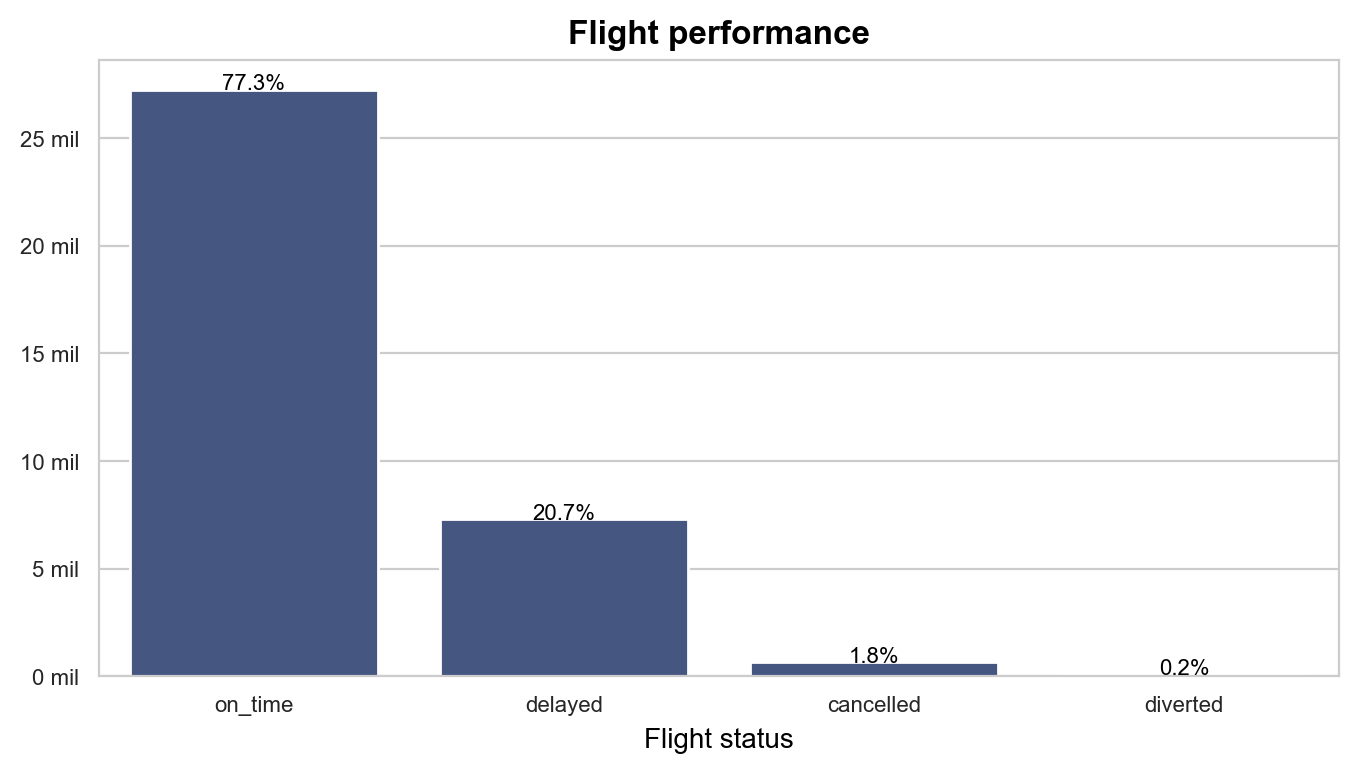

In [6]:
# calculate number of flights per flight status
flight_status_summary = flights['flight_status'].value_counts(normalize=True)
flight_status = flights['flight_status'].value_counts()


sns.barplot(x=flight_status.index, y=flight_status, color=BASE_COLOR)
plt.ylabel('')
plt.xlabel('Flight status')
plt.title('Flight performance')

locs, labels = plt.xticks()

# for each bar, print a % text at the top of each bar
for loc, label in zip(locs,labels):
    count = flight_status[label.get_text()]
    perc = flight_status_summary[label.get_text()]
    pct_string = '{:0.1f}%'.format(perc*100)
    plt.text(loc, count+0.01, pct_string, ha='center', color='black', size=8, weight='ultralight')

# improve y axis
ticks = np.arange(0, flight_status[0], 5000000)
labels = ['{:1.0f} mil'.format(tick/1000000) for tick in ticks]
plt.yticks(ticks,labels)

plt.show()

## Seasonal Analysis

### When is the best time of year/day of week/time of day to fly to minimise delays?

<!-- <span style="text-align: center; color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Seasonal Analysis</span>

<span style="color:blue; font-size:20px; line-height:30px; font-family: Calibri;">Monthly distributrion</span><br> -->

## Seasonal Analysis

### Monthly Distribution

<p>

In the first plot on the left in blue, which focus on the distribution of **delayed** flights, there are **2 strong peaks** visible:
- Christmas period in *December - March*
- During summer months *June - August*


In the second plot on the right in grey, which plot the distribution of **all** flights, there is not much variation in the total flights per month **even in the peak periods**. 

This indicates that throughout the year, roughly the same number of flights fly between locations, whilst **we experience more delays in airports during peak times**.

</p>

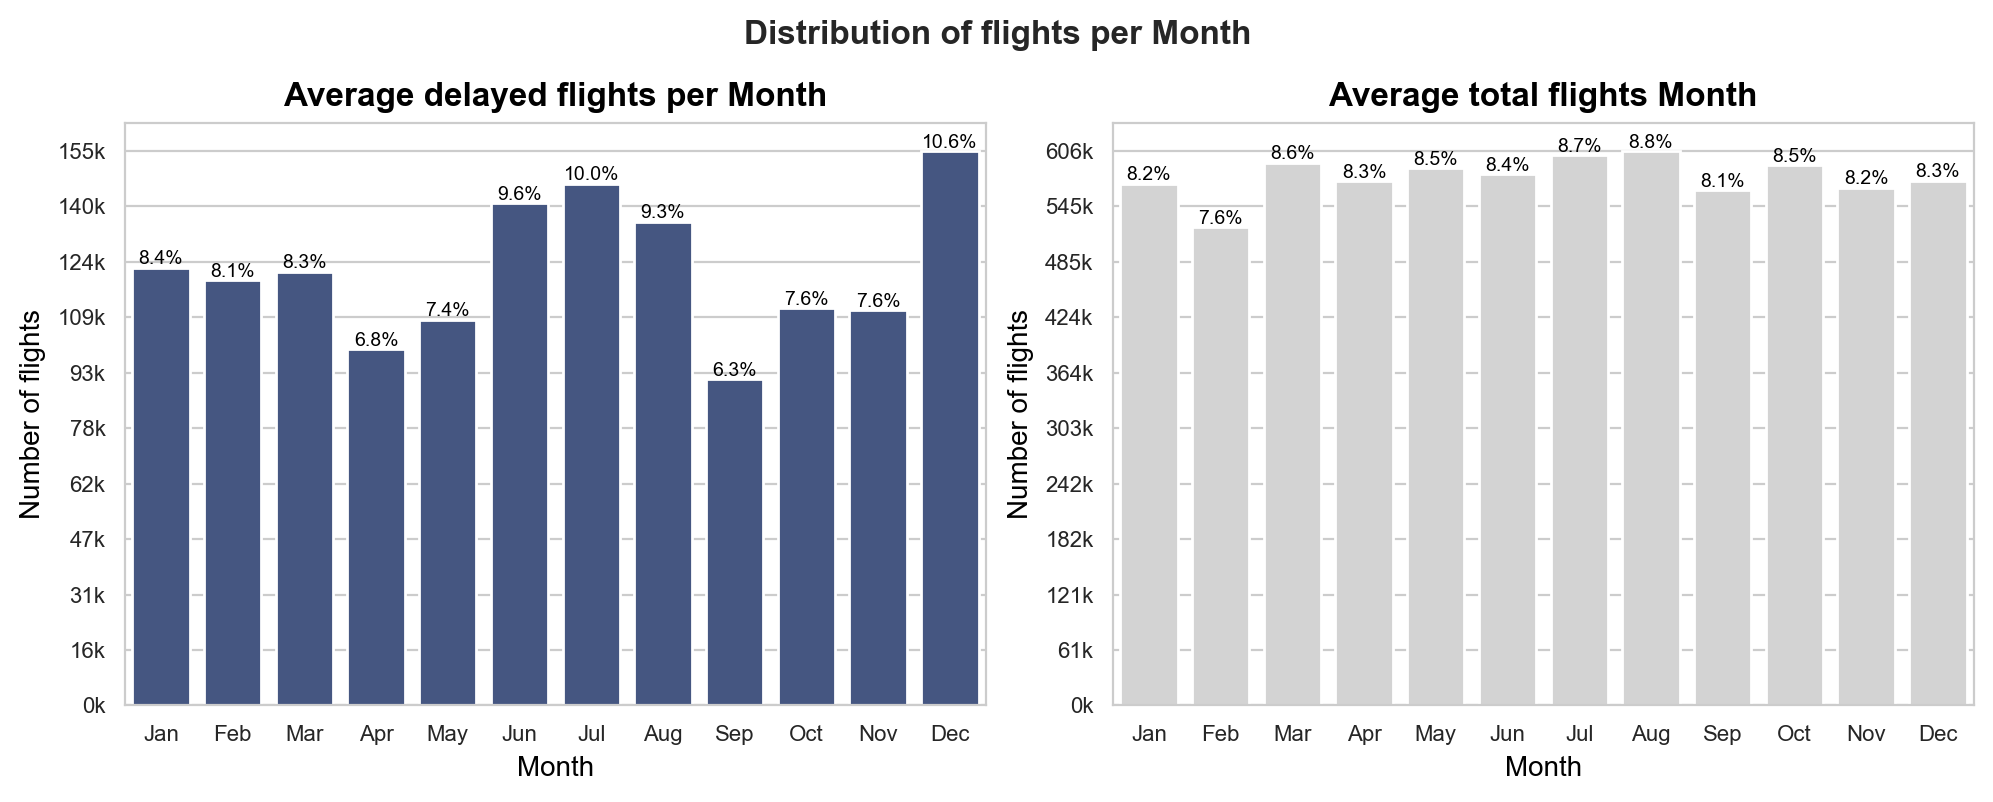

In [7]:
# build a timeseries dataset with datatime field as index
flight_timeseries_day = flights.groupby('dateh')['flight_status'].value_counts().unstack()
flight_timeseries_day['total_flights'] = flight_timeseries_day.sum(axis=1)

# summarize by month
freq = 'M'
flight_timeseries_month = flight_timeseries_day.resample(freq).sum()

vs.plot_period_side_by_side(df=flight_timeseries_month, col=flight_timeseries_month.index.strftime('%b'), annotate=True, title='Month', rotate=False, sharey=False)

#### Conclusion:  
Airports are more busy during peak periods, even though number of flights do not increase. This might be due to an increase in passengers on fully booked flights, thus more passengers in airports

## Seasonal Analysis

### Weekday Distribution

In the first plot on the left in blue, which focus on the distribution of **delayed** flights, delays are more likely to happen on Mondays, Thursdays and Fridays. 

In the second plot on the right in grey, which plot the distribution of **all** flights, weekdays have the same number of flights, weekends are more quiet

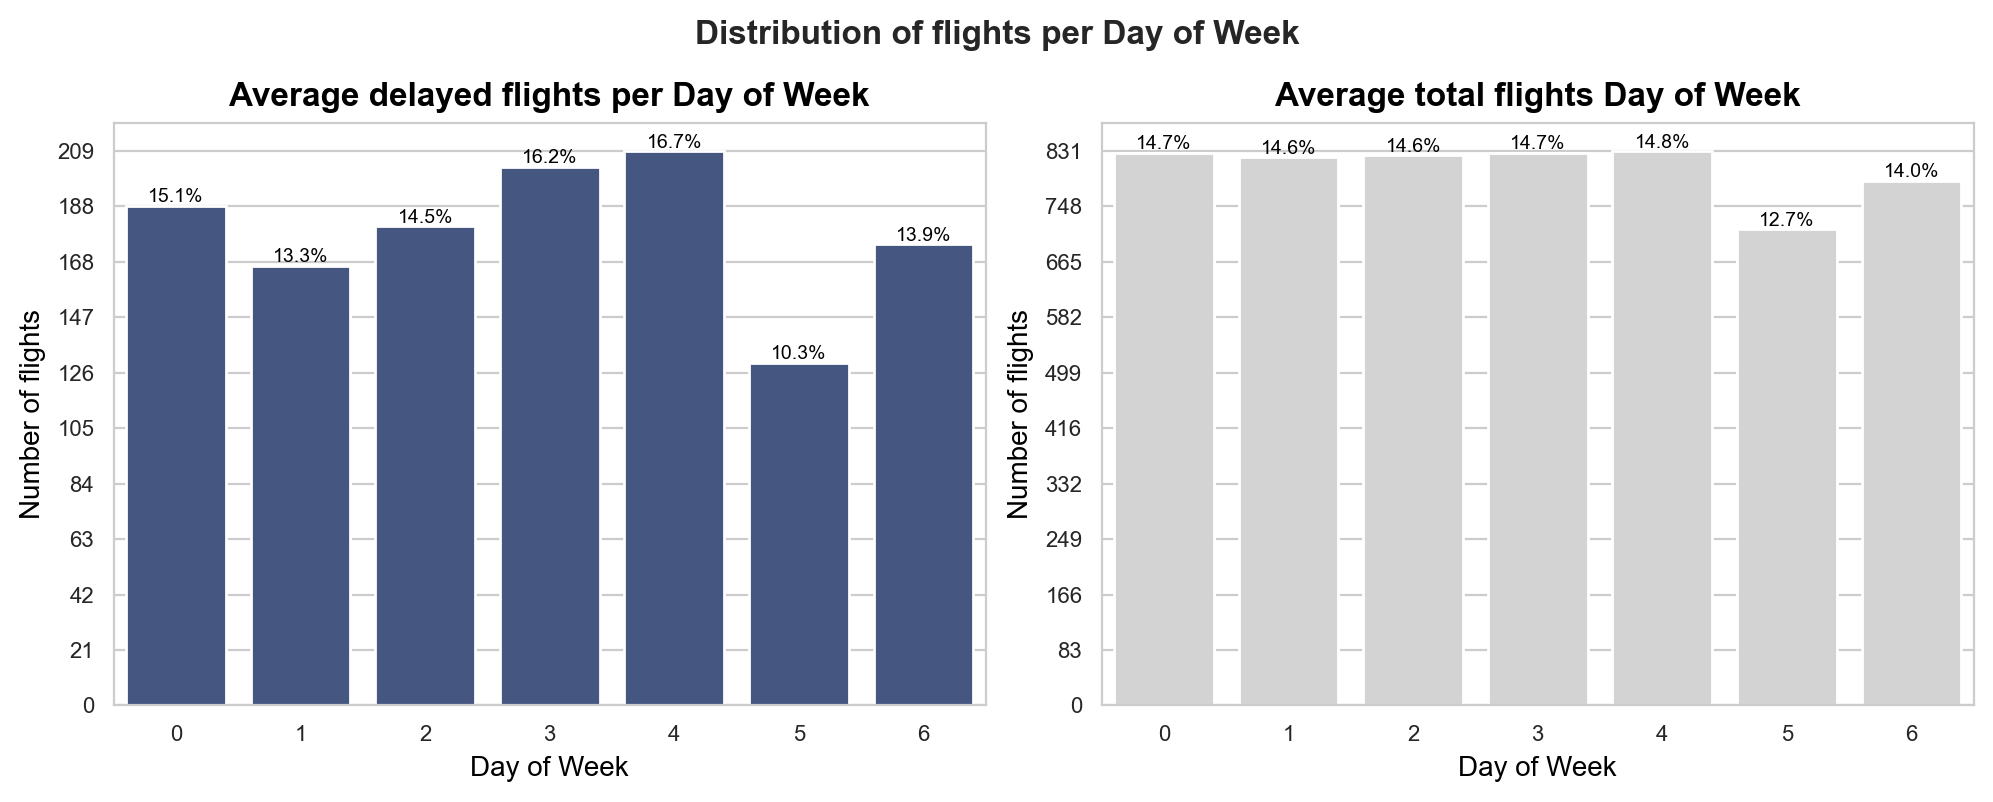

In [8]:
vs.plot_period_side_by_side(df=flight_timeseries_day, col=flight_timeseries_day.index.dayofweek, annotate=True, title='Day of Week', rotate=False, sharey=False)

## Seasonal Analysis

### Time of day Distribution

In the first plot on the left in blue, which focus on the distribution of **delayed** flights, delays are more likely to happen on Mondays, Thursdays and Fridays. 

In the second plot on the right in grey, which plot the distribution of **all** flights, weekdays have the same number of flights, weekends are more quiet

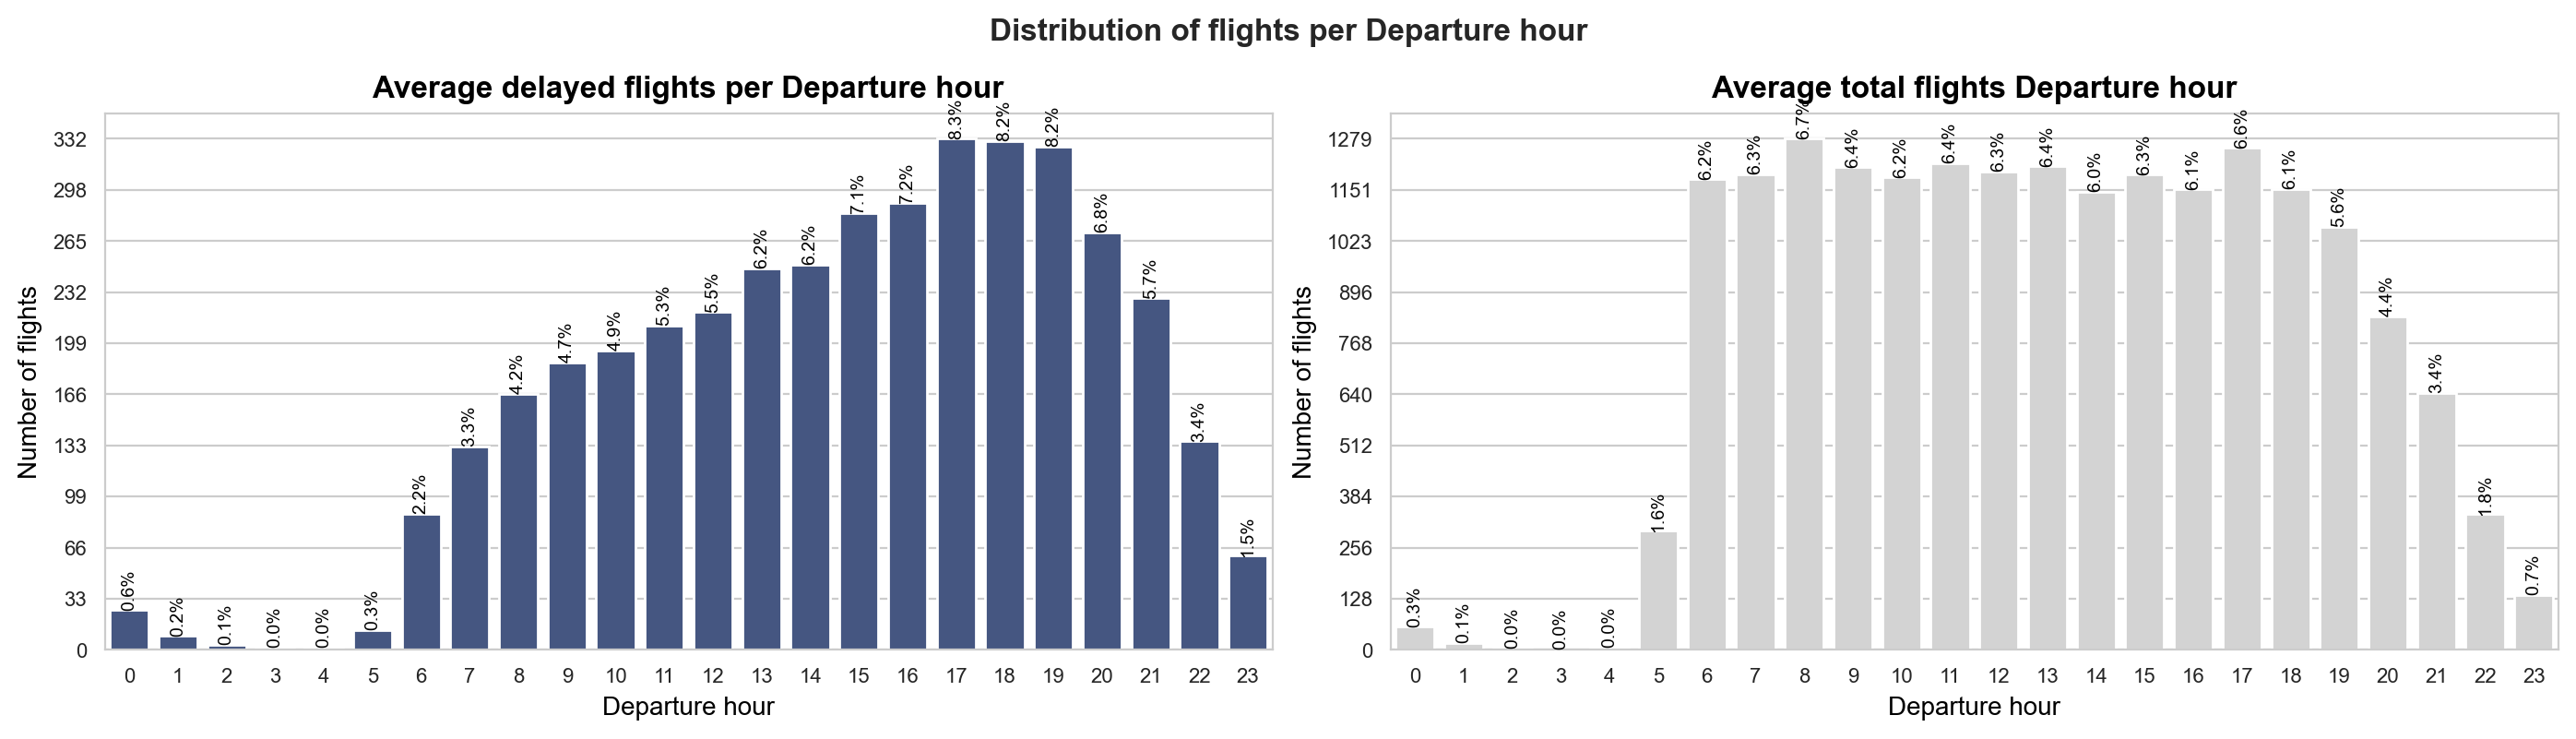

In [9]:
vs.plot_period_side_by_side(df=flight_timeseries_day, col=flight_timeseries_day.index.hour, annotate=True, title='Departure hour', rotate=True, sharey=False)

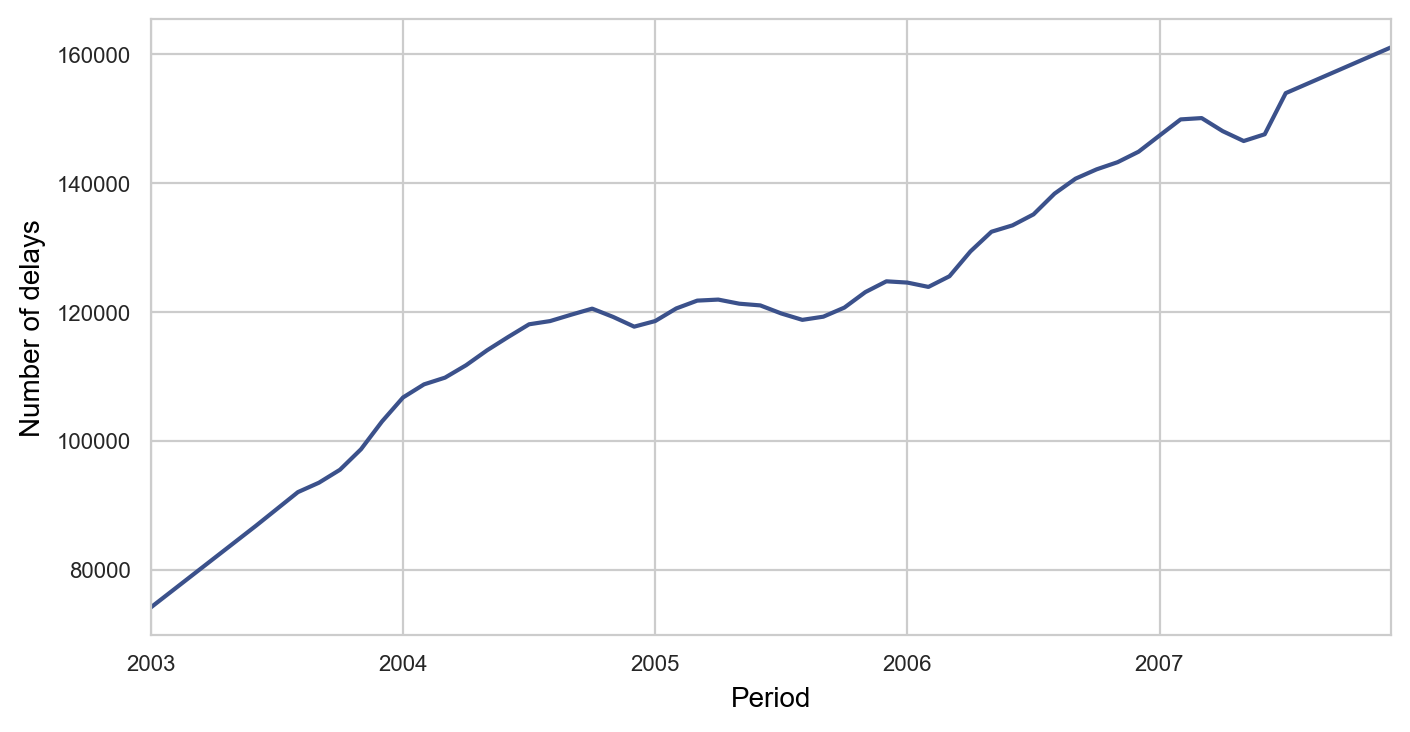

In [10]:
# print seasonal patterns using stats models
plt.rc("figure", figsize=(12,8))
flight_timeseries_month.dropna(inplace=True)
decomposition = sm.tsa.seasonal_decompose(flight_timeseries_month['delayed'], extrapolate_trend='freq')

# Plot the trend
plt.rc("figure", figsize=(8,4))
trend = decomposition.trend
ax = trend.plot(color=BASE_COLOR)
plt.xlabel('Period')
plt.ylabel('Number of delays')
plt.show()

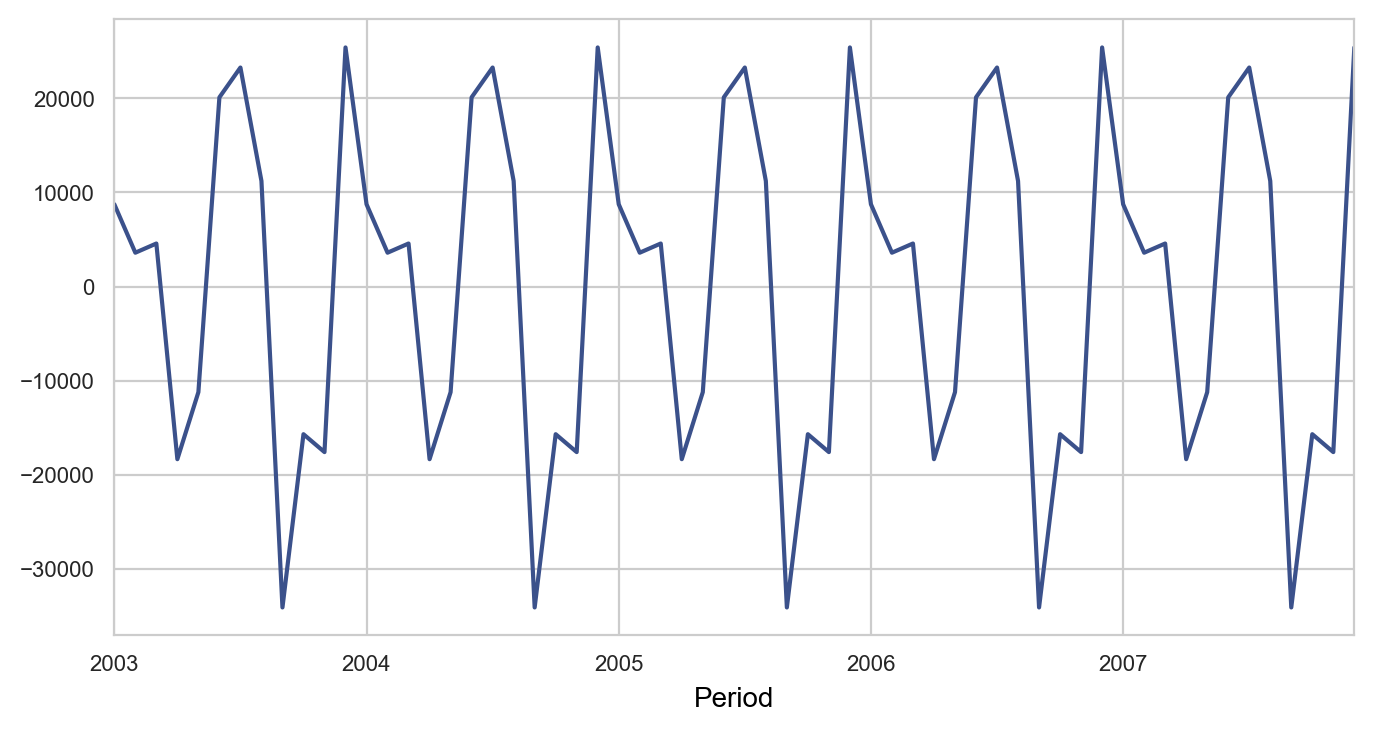

In [11]:
# Display the seasional pattern
season = decomposition.seasonal
ax = season.plot(color=BASE_COLOR)
plt.xlabel('Period')
plt.show()

## Seasonal Analysis

### When is the best time of year/day of week/time of day to fly to minimise delays?

- Delays decrease in spring/autumn months.
- Airports are more busy during peak periods, even though number of flights do not increase. This might be due to an increase in passengers on fully booked flights, thus more passengers in airports

## (Visualization 3)



### Generate Slideshow
Once you're ready to generate your slideshow, use the `jupyter nbconvert` command to generate the HTML slide show.  

In [14]:
# Use this command if you are running this file in local
!jupyter nbconvert Part_III_slide_deck.ipynb --to slides --no-input

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook Part_III_slide_deck.ipynb to slides
[NbConvertApp] Writing 1298085 bytes to Part_III_slide_deck.slides.html


> In the classroom workspace, the generated HTML slideshow will be placed in the home folder. 

> In local machines, the command above should open a tab in your web browser where you can scroll through your presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent slide. Make sure you remove all of the quote-formatted guide notes like this one before you finish your presentation! At last, you can stop the Kernel. 

### Submission
If you are using classroom workspace, you can choose from the following two ways of submission:

1. **Submit from the workspace**. Make sure you have removed the example project from the /home/workspace directory. You must submit the following files:
   - Part_I_notebook.ipynb
   - Part_I_notebook.html or pdf
   - Part_II_notebook.ipynb
   - Part_I_slides.html
   - README.md
   - dataset (optional)


2. **Submit a zip file on the last page of this project lesson**. In this case, open the Jupyter terminal and run the command below to generate a ZIP file. 
```bash
zip -r my_project.zip .
```
The command abobve will ZIP every file present in your /home/workspace directory. Next, you can download the zip to your local, and follow the instructions on the last page of this project lesson.
